<a href="https://www.kaggle.com/code/geazzy/ic-final-project-1?scriptVersionId=155564489" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Etapas:
1. **Examinar e entender os dados (Pré processamento)**
2. Criar um pipeline de entrada (Extraçao de características)
3. Criar o modelo de classificação
4. Treine o modelo
5. Avaliar modelo

# DATASET

O dataset possui 7909 imagens microscópicas de tecido  de tumores de mama coletadas de **82 pacientes**, usando diferentes fatores de ampliação (mag) (40X, 100X, 200X e 400X). As  imagem possuem 700X460 pixels, coloridas em 3 canais RGB, profundidade de 8 bits em cada canal, no formato PNG.

O conjunto de dados BreaKHis é dividido em dois grupos principais: tumores benignos e tumores malignos. Histologicamente benigno é um termo que se refere a uma lesão que não corresponde a nenhum critério de malignidade – por exemplo, atipia celular acentuada, mitose, ruptura de membranas basais, metástase, etc. Normalmente, os tumores benignos são relativamente “inocentes”, apresentam crescimento lento e permanecem localizado. Tumor maligno é sinônimo de câncer: a lesão pode invadir e destruir estruturas adjacentes (localmente invasiva) e se espalhar para locais distantes (metástase) para causar a morte.


Tanto os tumores de mama benignos quanto os malignos podem ser classificados em diferentes tipos com base na aparência das células tumorais ao microscópio. São eles:
* Benign:
    * Adenosis (A)
    * Fibroadenoma (F)
    * Phyllodes tumour (PT)
    * Tubular adenoma (TA)
* Malignant:
    * Carcinoma (DC)
    * Lobular carcinoma (LC)
    * Mucinous carcinoma (MC)
    * Papillary carcinoma (PC)
    

* Quantidade de paciente por tipo de tumor:

| Tipo de tumor   |   Quantidade |
|:-------------|-----------:|
| A            |          4 |
| DC           |         38 |
| F            |         10 |
| LC           |          5 |
| MC           |          9 |
| PC           |          6 |
| PT           |          3 |
| TA           |          7 |
| Total        |         82 |

* Distribuição das imagens por classe e fatores de ampliação
    
| Ampliação   |   Tumores benignos |   Tumores malignos |   Total de imagens |
|:------|----------------------:|-------------------------:|---------------:|
| 40    |                   625 |                     1370 |           1995 |
| 100   |                   644 |                     1437 |           2081 |
| 200   |                   623 |                     1390 |           2013 |
| 400   |                   588 |                     1232 |           1820 |
| Total |                  2480 |                     5429 |           7909 |
    
Fonte: https://www.kaggle.com/datasets/ambarish/breakhis e https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

    

# Pré processamento dos dados

In [1]:
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('/kaggle/input/breakhis/Folds.csv')
df1 = df[df["fold"] == 1].copy()  # Use copy to avoid modifying the original DataFrame
df1.rename(columns={"filename": "path"}, inplace=True)

for index, row in df1.iterrows():
    df1.loc[index, "filename"] = row["path"].split('/')[8]
    df1.loc[index, "class"] = row["path"].split('/')[3]
    df1.loc[index, "slide_id"] = row["path"].split('/')[8].split("-")[2]
    df1.loc[index, "tumor_type"] = row["path"].split('/')[8].split("-")[0].split("_")[2]

print(df1.head())

   fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   class slide_id tumor_type  
0  SOB_B_A-14-22549AB-100-001.png  benign  22549AB          A  
1  SOB_B_A-14-22549AB-100-002.png  benign  22549AB          A  
2  SOB_B_A-14-22549AB-100-003.png  benign  22549AB          A  
3  SOB_B_A-14-22549AB-100-004.png  benign  22549AB          A  
4  SOB_B_A-14-22549AB-100-005.png  benign  22549AB          A  


In [3]:
# Supondo que df seja o seu DataFrame
df_grouped = df1.groupby(['slide_id', 'mag'])['filename'].count().reset_index()

# Renomear a coluna de contagem para 'filename_count'
df_grouped.rename(columns={'filename': 'filename_count'}, inplace=True)
df_grouped.to_csv('df_grouped.csv', index=False)

print(df_grouped)

    slide_id  mag  filename_count
0      10147   40              15
1      10147  100              12
2      10147  200              22
3      10147  400              15
4      10926   40              11
..       ...  ...             ...
319     9146  400              24
320     9461   40              26
321     9461  100              36
322     9461  200              62
323     9461  400              31

[324 rows x 3 columns]


# Análise estatística do conjunto

In [4]:
print("")
print(f"Quantidade total de imagens: {len(df1)}")
print("")

print("Quantidade de paciente por tipo de tumor")
slide_id_counts = df1.groupby('tumor_type')['slide_id'].nunique()
total_count = slide_id_counts.sum()
slide_id_counts['Total'] = total_count
print(slide_id_counts.to_markdown())
print()

# Filtrar por classe 'benign'
df_class_b = df1[df1['class'] == 'benign']
# Filtrar por classe 'malignant'
df_class_m = df1[df1['class'] == 'malignant']

# Calcular o somatório do total de imagens para cada valor de magnificação para benign e malignant
total_images_per_mag_b = df_class_b.groupby('mag').size()
total_images_per_mag_m = df_class_m.groupby('mag').size().tolist()
#print(total_images_per_mag_b)

data = {
    'Total_Images_Benign': total_images_per_mag_b,
    'Total_Images_Malignant': total_images_per_mag_m,
    'Total_Images': df1.groupby('mag').size().tolist()
}

total_images_df = pd.DataFrame(data)

# Add a row representing the total sum for each column
total_images_df.loc['Total'] = total_images_df.sum()

print(total_images_df.to_markdown())



Quantidade total de imagens: 7909

Quantidade de paciente por tipo de tumor
| tumor_type   |   slide_id |
|:-------------|-----------:|
| A            |          4 |
| DC           |         38 |
| F            |         10 |
| LC           |          5 |
| MC           |          9 |
| PC           |          6 |
| PT           |          3 |
| TA           |          7 |
| Total        |         82 |

| mag   |   Total_Images_Benign |   Total_Images_Malignant |   Total_Images |
|:------|----------------------:|-------------------------:|---------------:|
| 40    |                   625 |                     1370 |           1995 |
| 100   |                   644 |                     1437 |           2081 |
| 200   |                   623 |                     1390 |           2013 |
| 400   |                   588 |                     1232 |           1820 |
| Total |                  2480 |                     5429 |           7909 |


In [5]:
def annotations(ax, total=None):
    # Show number in each bar
    if total is None:
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, -10),
                        textcoords='offset points')
    # Show number and percentage in each bar
    else:
        for p in ax.patches:
            count = int(p.get_height())
            percentage = (count / total) * 100
            ax.annotate(f'{count}\n({percentage:.1f}%)', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, -15),
                        textcoords='offset points')
    return ax

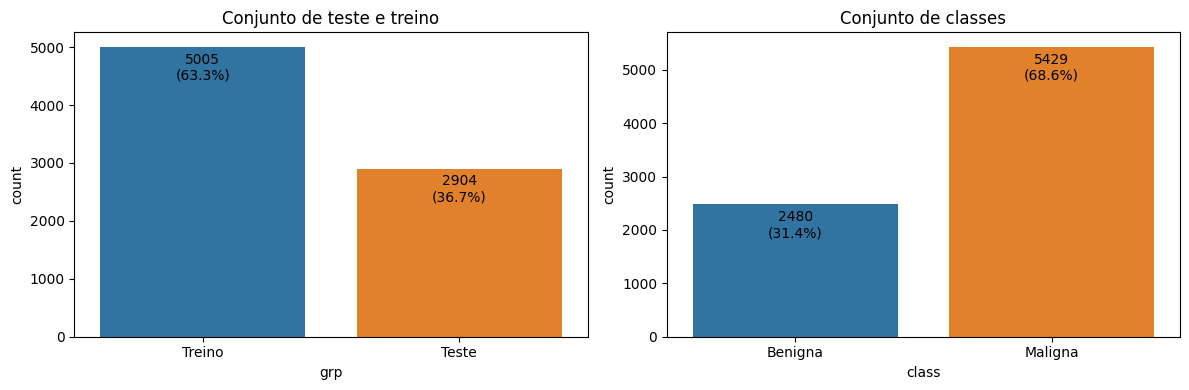

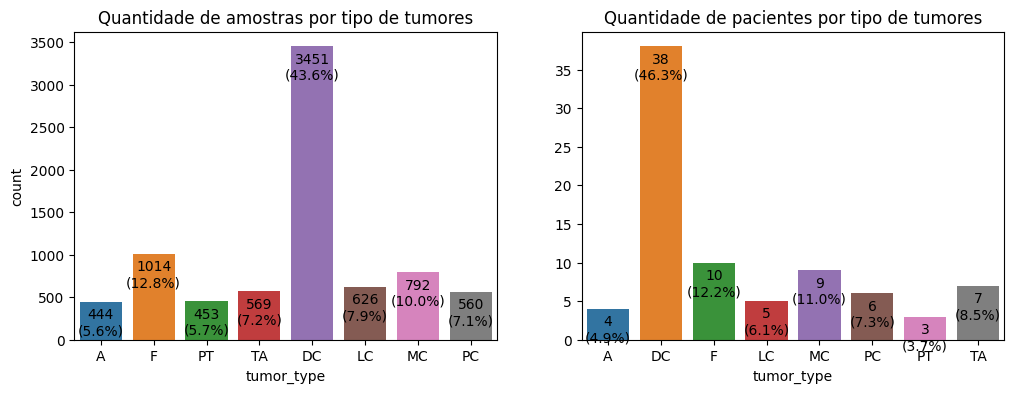

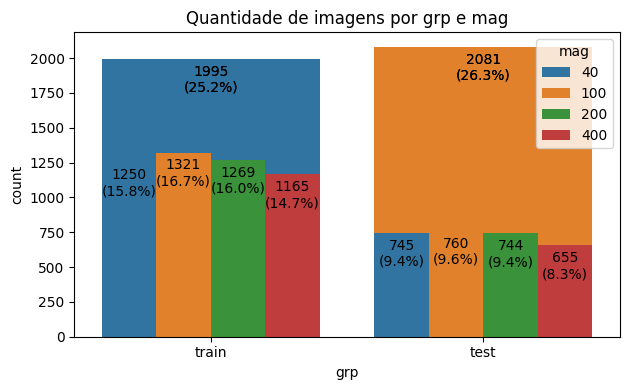

In [6]:

# Plot 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='grp', data=df1)
plt.title('Conjunto de teste e treino')
annotations(ax1, len(df1))
novos_rotulos = ['Treino', 'Teste']  # Replace with your desired labels
ax1.set_xticklabels(novos_rotulos)

# Plot 2
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='class', data=df1)
plt.title('Conjunto de classes')
annotations(ax2, len(df1))
ax2.set_xticklabels(['Benigna', 'Maligna'])

plt.tight_layout()
plt.show()

# Plot 3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax3 = sns.countplot(x='tumor_type', data=df1)
plt.title('Quantidade de amostras por tipo de tumores')
annotations(ax3, len(df1) )

# Plot 4
plt.subplot(1, 2, 2)
slide_id_counts = df1.groupby('tumor_type')['slide_id'].nunique()
ax4 = sns.barplot(x=slide_id_counts.index, y=slide_id_counts.values)
plt.title('Quantidade de pacientes por tipo de tumores')
annotations(ax4, slide_id_counts.sum())

# Plot 5
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ax5 = sns.countplot(x='mag', data=df1)
plt.title('Quantidade de imagens por mag')
annotations(ax5, len(df1))

# Plot 6
ax6 = sns.countplot(x='grp', hue='mag', data=df1)
plt.title('Quantidade de imagens por grp e mag')
annotations(ax6, len(df1))


plt.tight_layout()
plt.show()

* Quantidade de imagens por pasta

In [7]:
import os
import shutil
shutil.copy('/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh', '/kaggle/working/count_files.sh')
os.system('bash /kaggle/working/count_files.sh /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/')

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X : 16
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X : 17
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X : 15
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X : 13
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X : 31
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X : 30
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X : 35
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X : 36
/kaggle/input/breakhis/BreaKHis_v1/BreaKHi

0

* Amostras por cada tipo de tumor

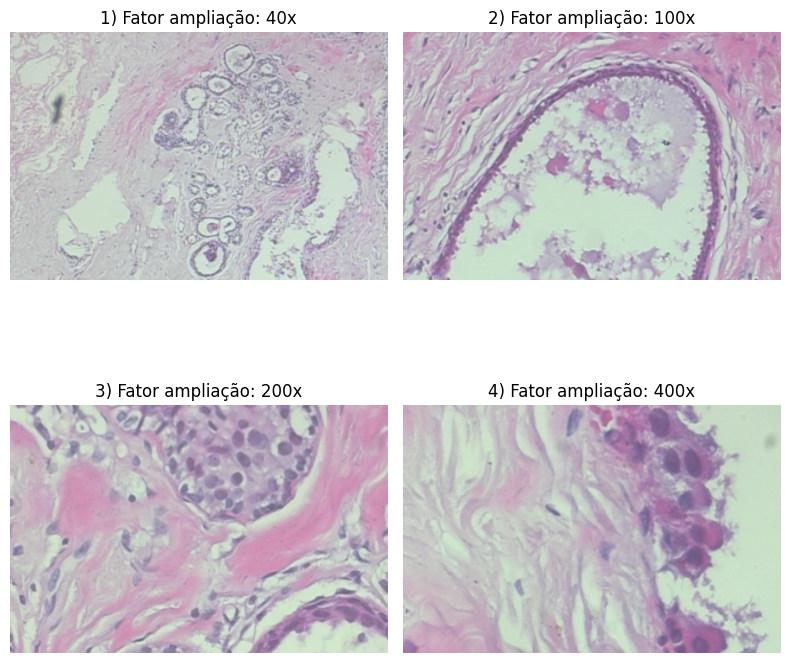

None

In [8]:
# Assuming df1 is your DataFrame
grouped_df1 = df1.groupby('mag').first() ## mesma imagem em fator de ampliação diferente.

# Set the desired width and height
image_width = 4
image_height = 4

# Number of images per row and column
num_images_per_row = 2
num_images_per_col = 2

# Create a grid layout
fig, axes = plt.subplots(num_images_per_col, num_images_per_row, figsize=(num_images_per_row * image_width, num_images_per_col * image_height))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
i=0
for (index, row), ax in zip(grouped_df1.iterrows(), axes.flatten()):
    i=i+1
    img_path = "/kaggle/input/breakhis/BreaKHis_v1/" + row['path']
    
    # Load and display the image
    img = plt.imread(img_path)
    ax.imshow(img)
#     ax.set_title(f"\nArquivo: {row['filename']}\nClasse: {row['class']}\n Fator ampliação: {index}")
    ax.set_title(f"{i}) Fator ampliação: {index}x")
    ax.axis('off')  # Turn off axis labels
    
# Adjust layout
plt.tight_layout()

# Display the plot
display(plt.show())